In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import warnings
#from math import log
#import numpy as np


In [2]:
from fconcrete import Load, Node, Beam, SingleBeamElement, Concrete, Rectangle, Section, ConcreteSteels

material = Concrete(fck_in_mpa=30, aggressiveness=3)
section = Rectangle(0.1,1, material)

f1 = Load.PontualLoad(-20000, x=2)
f4 = Load.UniformDistributedLoad(-100000, x_begin=0, x_end=4)

n1 = Node.SimpleSupport(x=0)
n2 = Node.SimpleSupport(x=4)
n3 = Node.SimpleSupport(x=6)
n4 = Node.SimpleSupport(x=10)

bar1 = SingleBeamElement([n1, n2], section)
bar2 = SingleBeamElement([n2, n3], section)
bar3 = SingleBeamElement([n3, n4], section)

beam = Beam(
    loads = [f1, f4],
    bars = [bar1, bar2, bar3],
    steel= ConcreteSteels(diameters=[8])
)

In [4]:
x_decalaged, momentum_positive, momentum_negative = beam.getDecalagedMomentumDiagram()

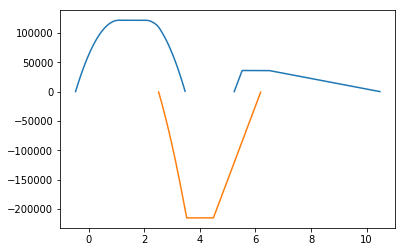

In [5]:
plt.plot(x_decalaged, momentum_positive)
plt.plot(x_decalaged, momentum_negative)

In [23]:
self = beam

def getDecalagedMomentumDiagram(self, division=1000):
    x, momentum_diagram = beam.getMomentumDiagram()
    x_decalaged, decalaged_x_left, decalaged_x_right, join_decalaged_x_order = __decalageds_x_axis(self, x)
    momentum_positive, momentum_negative = __decalaged_momentums(x_decalaged,
                                                                decalaged_x_left,
                                                                decalaged_x_right,
                                                                join_decalaged_x_order,
                                                                momentum_diagram)
    momentum_positive = __join_momentum_peak(momentum_positive)
    momentum_negative = __join_momentum_peak(momentum_negative)
    
    return x_decalaged, momentum_positive, momentum_negative
    
def __decalageds_x_axis(self, x):
    decalaged_x_left = np.array([])
    decalaged_x_right = np.array([])
    warnings.warn("Must improve a_l calculus", DeprecationWarning)
    for beam_element in self.bars:
        a_l = 0.5*beam_element.section.d
        position_in_beam_element = x[(x>=beam_element.n1.x) & (x<=beam_element.n2.x)]
        decalaged_x_left_temp = position_in_beam_element - a_l
        decalaged_x_right_temp = position_in_beam_element + a_l
        decalaged_x_left = np.concatenate((decalaged_x_left, decalaged_x_left_temp))
        decalaged_x_right = np.concatenate((decalaged_x_right, decalaged_x_right_temp))
    
    join_decalaged_x = np.concatenate((decalaged_x_left, x, decalaged_x_right))
    join_decalaged_x_order = join_decalaged_x.argsort()
    x_decalaged = join_decalaged_x[join_decalaged_x_order]
    
    return x_decalaged, decalaged_x_left, decalaged_x_right, join_decalaged_x_order


def __decalaged_momentums(x_decalaged,
                        decalaged_x_left,
                        decalaged_x_right,
                        join_decalaged_x_order,
                        momentum_diagram):
    momentum_decalaged_diagram = np.concatenate((momentum_diagram, momentum_diagram, momentum_diagram))[join_decalaged_x_order]

    momentum_left = np.interp(x_decalaged, decalaged_x_left, momentum_diagram)
    momentum_right = np.interp(x_decalaged, decalaged_x_right, momentum_diagram)

    momentum_positive = np.max((momentum_left, momentum_right), axis=0)
    momentum_positive = np.where(momentum_positive<0, np.nan, momentum_positive)

    momentum_negative = np.min((momentum_left, momentum_right), axis=0)
    momentum_negative = np.where(momentum_negative>0, np.nan, momentum_negative)
    
    return momentum_positive, momentum_negative  
    
def __join_momentum_peak(_momentum):
    momentum = _momentum.copy() 
    peaks, _ = find_peaks(np.absolute(momentum))
    for peak_index in 2*np.arange(len(peaks)//2):
        x_momentum_index = peaks[peak_index]
        next_x_momentum_index = peaks[peak_index+1]
        momentum[x_momentum_index:next_x_momentum_index] = momentum[x_momentum_index]
    return momentum

In [24]:
x_decalaged, momentum_positive, momentum_negative = getDecalagedMomentumDiagram(self)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Must improve a_l calculus


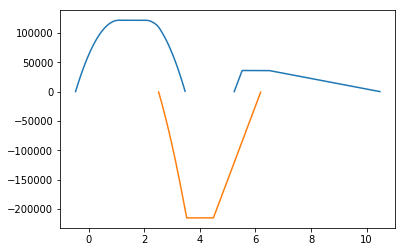

In [22]:
plt.plot(x_decalaged, momentum_positive)
plt.plot(x_decalaged, momentum_negative)

# Rascunho

In [ ]:
def __join_decalaged_momentums_in_single_axis(x_decalaged, momentum_positive, momentum_negative):
    
    momentum_in_beam_element = momentum_diagram[(x>=beam_element.n1.x) & (x<=beam_element.n2.x)]
    peaks, _ = __find_peaks(np.absolute(momentum_diagram))
    x_start_interval = beam_element.n1.x
    for x_end_interval in x[peaks]:
        positive = momentum_in_beam_element[peaks] > 0
        x[(x>=x_start_interval) & (x<=x_end_interval) & (momentum_diagram<0)] + a1
        x[(x>=x_start_interval) & (x<=x_end_interval)] - a1
        x_start_interval = x_end_interval
    
    return np.array([x_value+al if x_value>max_momentum_position else x_value-al for x_value in x])
    
        

In [9]:
x, necessary_area = beam.getSteelAreaDiagram()
x, y = beam.getComercialSteelAreaDiagram()
number_of_bars = np.array(y)[:,0]
bar_diameter = np.array(y)[:,1]
comercial_area = np.array(y)[:,2]

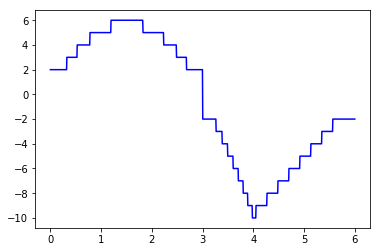

In [14]:
fig, ax1 = plt.subplots()
#ax2 = ax1.twinx()
#ax1.plot(x, comercial_area, 'g-')
ax1.plot(x, number_of_bars, 'b-')
plt.show()

In [70]:
bar_removal = number_of_bars.copy()
for number in np.unique(number_of_bars):
    bar_removal = np.vstack([bar_removal, number*(number_of_bars==number)])
bar_removal = bar_removal[1:]

In [81]:
bar_removal = np.where(bar_removal==0, np.nan, bar_removal)

In [89]:
bar_removal

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

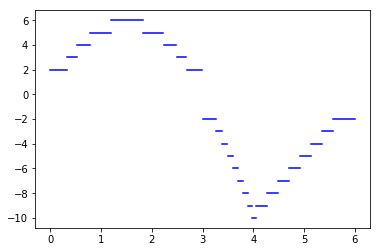

In [88]:
for bar in bar_removal:
    plt.plot(x, bar, 'b')
    
plt.show()

In [57]:
a = np.array([1, 2, 4])
a1 = np.vstack([a, [5,6,6]])
a2 = np.vstack([a1, [5,6,6]])

In [55]:
a2

array([[1, 2, 4],
       [5, 6, 6],
       [5, 6, 6]])

In [35]:
np.array([np.array([[1,2,3],[4,5,6]]),np.array([5,7,8])])

array([array([[1, 2, 3],
       [4, 5, 6]]), array([5, 7, 8])], dtype=object)

In [55]:
x, necessary_area = beam.getSteelAreaDiagram()
x, y = beam.getComercialSteelAreaDiagram()
number_of_bars = np.array(y)[:,0]
bar_diameter = np.array(y)[:,1]
comercial_area = np.array(y)[:,2]

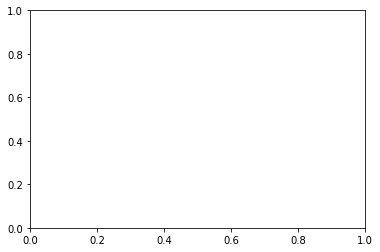

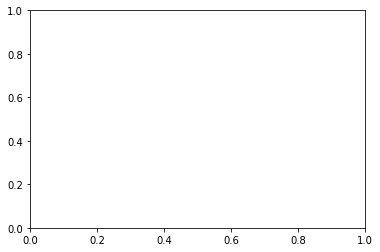

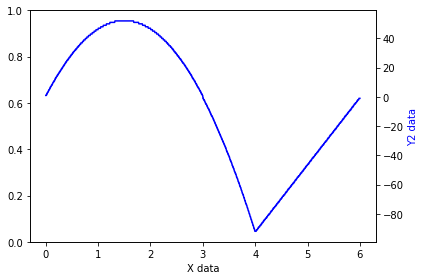

In [69]:
plt.cla()
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
#ax1.plot(x, comercial_area, 'g-')
ax2.plot(x, number_of_bars, 'b-')

ax1.set_xlabel('X data')
#ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [7]:
gapminder_us = gapminder[gapminder.country=="United States"]

Text(0,0.5,'Y2 data')

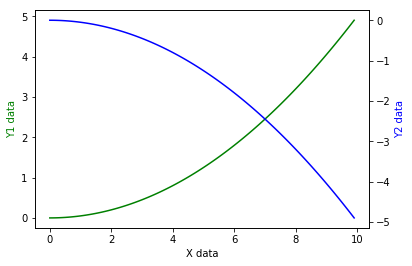

In [49]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0, 10, 0.1)
y1 = 0.05 * x**2
y2 = -1 *y1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

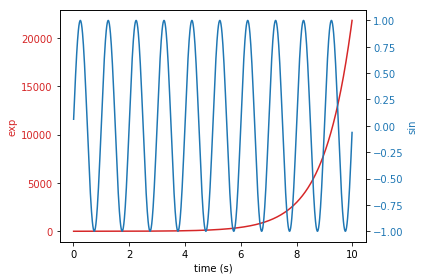

In [67]:
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
